In [8]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 

In [9]:
class DataProcess:
    INVALID_ITEM = -1
    def __init__(self, data_file, data_size, config):
        self.file = data_file
        self.data_size = data_size
        self.fake_eps = config['fake_eps']
        self.min_delay = config['min_delay']
        self.max_delay = config['max_delay']
        self.max_bw = np.log(config['max_bw']*1024*1024)
        self.cong_rate = config['cong_rate']
        self.stat_size = config['stat_size']
        self.avg_weight = config['avg_weight']
        self.link_delay_map = {}
        self.path_delay_map = {}
        self.link_loads_map = {}
        self.valid_delay_map = {}
        self.valid_loads_map = {}
        self.delay_limit_map = {}
        self.quality_map = {}
        self.dataset = []
        self.target_dpids = self._get_target_dpids()
    
    def preprocess(self):
        with open(self.file, 'r+') as fp:
            for _ in range(self.data_size):
                line = fp.readline()
                if not line:
                    break 
                self._get_link_delay(line)
                self._get_data_item(line)
                self._get_link_quality(line)
    
    def _get_target_dpids(self):
        target_dpids = set()
        for ep in self.fake_eps:
            dpid = ep[0]
            target_dpids.add(dpid)
        return target_dpids
    
    def _get_link_delay(self, line):
        res_list = line.split()
        link = ''.join(res_list[:3])
        loads = float(res_list[-1])
        path_delay = float(res_list[-2])
        cs_delay = float(res_list[-3])
        sc_delay = float(res_list[-4])
        link_delay = path_delay - (cs_delay + sc_delay)/2
        if link_delay < self.min_delay:
            link_delay = self.min_delay
        link_delays = self.link_delay_map.setdefault(link, [])
        link_delays.append(link_delay)
        link_loads = self.link_loads_map.setdefault(link, [])
        link_loads.append(loads)
        path_delays = self.path_delay_map.setdefault(link, [])
        path_delays.append(path_delay)
    
    def _get_valid_delay(self, link, delay):
        valid_list = self.valid_delay_map.setdefault(link, [self.max_delay])
        if delay == DataProcess.INVALID_ITEM:
            if len(valid_list) < self.stat_size:
                item_list = self.link_delay_map[link]
                s_loc = -min(len(item_list), self.stat_size)
                valid_delay = np.median(item_list[s_loc:])
            else:
                valid_delay = np.median(valid_list)
        else:
            if len(valid_list) >= self.stat_size:
                valid_list.pop(0)
            valid_list.append(delay)
            if len(valid_list) < len(self.avg_weight):
                valid_delay = sum(valid_list)/len(valid_list)
            else:
                s_loc = -len(self.avg_weight)
                valid_delay = sum([self.avg_weight[i]*d \
                    for i, d in enumerate(valid_list[s_loc:])])
        return valid_delay
        
    def _get_valid_loads(self, link, loads):
        valid_list = self.valid_loads_map.setdefault(link, [0])
        if loads == DataProcess.INVALID_ITEM:
            valid_loads = 0
        else:
            if len(valid_list) >= self.stat_size:
                valid_list.pop(0)
            valid_list.append(loads)
            if len(valid_list) < len(self.avg_weight):
                valid_loads = sum(valid_list)/len(valid_list)
            else:
                s_loc = -len(self.avg_weight)
                valid_loads = sum([self.avg_weight[i]*d \
                    for i, d in enumerate(valid_list[s_loc:])])
        return valid_loads
        
    def _get_link_quality(self, line):
        res_list = line.split()
        link = ''.join(res_list[:3])
        delay = float(res_list[-2])
        loads = float(res_list[-1])
        
        # The key idea of this tricks locates at that, the delay beyond a so called 'max_delay' should
        # make no sense to indicate the link quality, as well as the reliability of the links.
        # Statistic of the median delay of the links of the target dpid, so as to obtain the valid delay
        # which is used to indicated the reliability of the links.
        
        if delay > self.max_delay:
            delay = self._get_valid_delay(link, DataProcess.INVALID_ITEM)
            loads = self._get_valid_loads(link, DataProcess.INVALID_ITEM)
        else:
            delay = self._get_valid_delay(link, delay)
            loads = self._get_valid_loads(link, loads)
            
        tq = 1 - np.tanh(delay/self.max_delay)
        lq = 1 / (1 + np.exp(-(loads-self.max_bw*self.cong_rate)))
        
        # The degree of indicating link quality mainly depends on the delay quality, e.g., 
        # Link A: high loads, low delay
        # Link B: low loads, low delay
        # Link C: high loads, high delay
        # Link D: low loads, high delay 
        # we hat A > B > C > D
        # Eq. Q = (Qt + np.exp(Qt-max_Qt) * Ql) / 2, where max_Qt = 1-np.tanh(0) = 1
        quality = tq * (1 + np.exp(tq - 1) * lq) / 2 
        quality_list = self.quality_map.setdefault(link, [])
        quality_list.append(quality)
    
    def _get_data_item(self, line):
        res_list = line.split()
        link = ''.join(res_list[:3])
        dpid = link.split(':')[0]
        if not dpid in self.target_dpids:
            return 
        path_delay = float(res_list[-2])
        cs_delay = float(res_list[-3])
        sc_delay = float(res_list[-4])
        delay = path_delay - (cs_delay + sc_delay)/2
        if delay < self.min_delay:
            delay = self.min_delay
        if any([x in link for x in self.fake_eps]):
            is_forged_link = True 
        else:
            is_forged_link = False 
        data_item = [cs_delay, sc_delay, delay, is_forged_link]
        self.dataset.append(data_item)
    
    def query_quality_map(self):
        return self.quality_map 
    
    def query_delay_map(self):
        return self.link_delay_map
    
    def query_delay_map2(self):
        return self.path_delay_map
    
    def query_dataset(self):
        return np.array(self.dataset)

In [10]:
sns.set_theme(style='ticks', font='Times New Roman', font_scale=1.3)

In [11]:
# config dataset parameters and running parameters 

# data_size: the number of data items
# fake_eps: the endpoints of the fabricated links.
# min_delay: tx delay, set to 0.5ms in Mininet.
# max_delay: tx delay, set to 5ms empirically, a delay larger than max_delay should no longer 
#   indicate the link quality effectively.
# max_bw: maximum bandwidth, set to 100Mb/s in Mininet.
# cong_rate: congestion ratio, 80%.
# stat_size: do the statistic each 100 items.
# avg_weight: moving average of the latest 4 items.

ds_config = {
    'fake_eps': ['2:1', '4:1'],
    'min_delay': 0.5,
    'max_delay': 5,
    'max_bw': 100,
    'cong_rate': 0.8,
    'stat_size': 100,
    'avg_weight': [0.1, 0.2, 0.3, 0.4],
}

data_files = [
    r'../dataset/5switches/sock_link_0.5_no_load_no_attack.txt',
    r'../dataset/5switches/switch_link_0.5_no_load_no_attack.txt',
]

data_size = 2000

normal_link_1 = '2:2->1:2'
fabricated_link_1 = '2:1->4:1'

normal_link_2 = '2:2->1:2'
fabricated_link_2 = '2:3->4:2'

processors = [DataProcess(data_file, data_size, ds_config) for data_file in data_files]

for processor in processors:
    processor.preprocess()

delays = [processor.query_delay_map() for processor in processors]
qualities = [processor.query_quality_map() for processor in processors] 

ib_delay = pd.DataFrame({
    'normal_link': delays[0][normal_link_1],
    'fabricated_link': delays[0][fabricated_link_1]
})

ib_linkq = pd.DataFrame({
    'normal_link': qualities[0][normal_link_1],
    'fabricated_link': qualities[0][fabricated_link_1]
})

s_delay = pd.DataFrame({
    'normal_link': delays[1][normal_link_2],
    'fabricated_link': delays[1][fabricated_link_2]
})

s_linkq = pd.DataFrame({
    'normal_link': qualities[1][normal_link_2],
    'fabricated_link': qualities[1][fabricated_link_2]
})


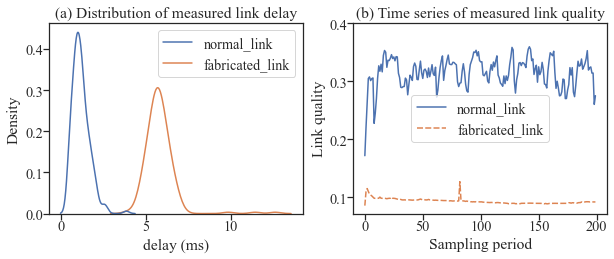

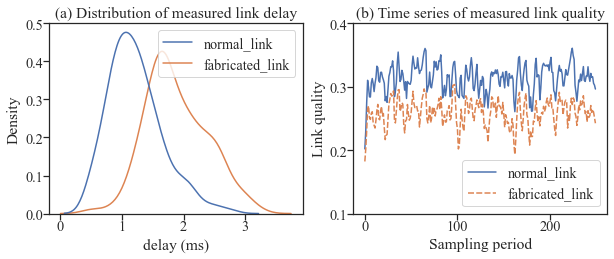

In [12]:
def show_delay_quality(delay, linkq, method):
    f, axes = plt.subplots(1, 2, figsize=(10, 3.5))
    sns.kdeplot(data=delay, ax=axes[0])
    sns.lineplot(data=linkq, ax=axes[1])
    axes[0].set_title('(a) Distribution of measured link delay')
    axes[0].set_xlabel('delay (ms)')
    axes[1].set_title('(b) Time series of measured link quality')
    axes[1].set_xlabel('Sampling period')
    axes[1].set_ylabel('Link quality')
    axes[1].set_yticks([0.1, 0.2, 0.3, 0.4])
    for i in range(2):
        axes[i].tick_params(pad=0)
    f.savefig('{}.png'.format(method), format='png', bbox_inches='tight', dpi=300)

show_delay_quality(ib_delay, ib_linkq, 'IB-LFA')
show_delay_quality(s_delay, s_linkq, 'S-LFA')